In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
import os
import sys
from pathlib import Path

path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))

from src.data.save_results import save_model_scores, save_model_predictions
from src.utils.data_loader import load_preprocessed_data

# Define multiple scorings
cv_scorings = {
    "CV RMSE": "neg_root_mean_squared_error",
    "CV MAE": "neg_mean_absolute_error",
    "CV R2": "r2"
}

target_variables = [
    "temperature_2m_max",
    "apparent_temperature_min",
    "relative_humidity_2m_max",
    "wind_speed_10m_max",
    "winddirection_10m_dominant",
    "rain_sum",
    "shortwave_radiation_sum"
]

for target_variable in target_variables:
    data = load_preprocessed_data(target_variable)

    DATA = data["DATA"]
    TRAINED_DATA = data["TRAINED_DATA"]
    METHOD = data["METHOD"]

    X_train = data["X_train"]
    X_test_selected = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    preprocessor = data["preprocessor"]

    # Pipeline cho GBR
    gbr_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ])

    tscv = TimeSeriesSplit(n_splits=5)

    # Dictionary to store CV results
    cv_results = {}

    for name, scoring in cv_scorings.items():
        scores = cross_val_score(
            gbr_pipeline, X_train, y_train,
            cv=tscv, scoring=scoring
        )
        mean_score = -np.mean(scores) if "neg_" in scoring else np.mean(scores)
        std_score = np.std(scores)
        cv_results[name] = (mean_score, std_score)

    # Train and evaluate on test set
    gbr_pipeline.fit(X_train, y_train)
    y_pred_gbr = gbr_pipeline.predict(X_test_selected)

    mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
    rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
    r2_gbr = r2_score(y_test, y_pred_gbr)

    y_train_pred = gbr_pipeline.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Transform X_train via preprocessor to calculate VIF
    X_train_transformed = preprocessor.fit_transform(X_train)
    if hasattr(X_train_transformed, "toarray"):
        X_train_transformed = X_train_transformed.toarray()

    X_vif = pd.DataFrame(X_train_transformed)
    vif_data = pd.DataFrame()
    vif_data["feature_index"] = range(X_vif.shape[1])
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

    # === Print results ===
    print(f"[RESULT] Gradient Boosting Regressor - {target_variable}")
    print("Cross-Validation Scores:")
    for name, (mean_score, std_score) in cv_results.items():
        print(f"  [{name}]: {mean_score:.2f} ± {std_score:.2f}")
    print("\nTest Set Evaluation:")
    print(f"  [MAE]: {mae_gbr:.2f}")
    print(f"  [RMSE]: {rmse_gbr:.2f}")
    print(f"  [Train R2 Score]: {r2_train:.2f}")
    print(f"  [Test R2 Score]: {r2_gbr:.2f}")
    print("\n[VIF Scores]")
    print(vif_data.sort_values("VIF", ascending=False).head(20))

    # === Save results ===
    PATH = DATA / "scores&predictions" / METHOD / target_variable
    save_model_scores(
        "GradientBoostingRegressor(gbr)",
        mae_gbr,
        rmse_gbr,
        r2_gbr,
        cv_results["CV RMSE"][0],  # mean RMSE
        cv_results["CV RMSE"][1],  # std RMSE
        cv_results["CV MAE"][0],  # mean MAE
        cv_results["CV MAE"][1],  # std MAE
        cv_results["CV R2"][0],  # mean R2
        cv_results["CV R2"][1],  # std R2
        PATH
    )
    save_model_predictions("GradientBoostingRegressor(gbr)", y_test, y_pred_gbr, PATH)


[RESULT] Gradient Boosting Regressor - temperature_2m_max
Cross-Validation Scores:
  [CV RMSE]: 2.58 ± 0.11
  [CV MAE]: 1.96 ± 0.09
  [CV R2]: 0.78 ± 0.01

Test Set Evaluation:
  [MAE]: 1.95
  [RMSE]: 2.53
  [Train R2 Score]: 0.81
  [Test R2 Score]: 0.79

[VIF Scores]
   feature_index       VIF
6              6  4.063096
7              7  4.006314
5              5  1.630879
1              1  1.618778
2              2  1.565625
3              3  1.208313
0              0  1.186168
4              4  1.106304
8              8  1.101500
[RESULT] Gradient Boosting Regressor - apparent_temperature_min
Cross-Validation Scores:
  [CV RMSE]: 3.57 ± 0.11
  [CV MAE]: 2.70 ± 0.09
  [CV R2]: 0.79 ± 0.01

Test Set Evaluation:
  [MAE]: 2.68
  [RMSE]: 3.50
  [Train R2 Score]: 0.82
  [Test R2 Score]: 0.80

[VIF Scores]
   feature_index       VIF
6              6  4.063096
7              7  4.006314
5              5  1.630879
1              1  1.618778
2              2  1.565625
3              3  1.2083

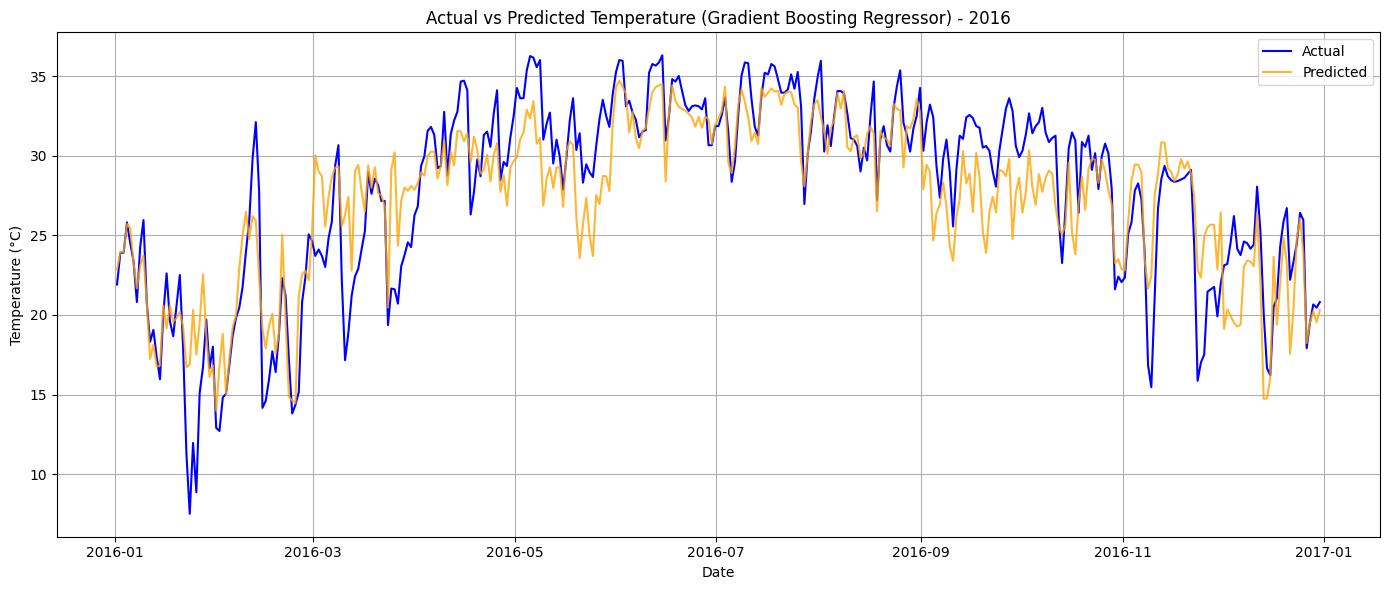

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Đọc dữ liệu và chuyển đổi cột date
test_df = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/temperature_2m_max/test_df.csv", parse_dates=["date"])
model_predictions = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/temperature_2m_max/model_predictions.csv")

# Kiểm tra điều kiện: actual == temperature_2m_max
matching = model_predictions["actual"].values == test_df["temperature_2m_max"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions["date"] = np.where(
    matching,
    test_df["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions["date"] = pd.to_datetime(model_predictions["date"], errors="coerce")

# Lọc khoảng thời gian từ 01/01/2016 đến 31/12/2016
mask = (model_predictions["date"] >= "2016-01-01") & (model_predictions["date"] <= "2016-12-31")
subset_df = model_predictions[mask]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(subset_df["date"], subset_df["actual"], label="Actual", color="blue")
plt.plot(subset_df["date"], subset_df["GradientBoostingRegressor(gbr)_pred"], label="Predicted", color="orange", alpha=0.8)
plt.title("Actual vs Predicted Temperature (Gradient Boosting Regressor) - 2016")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
